#HaSpeeDe
[Task Description](https://github.com/msang/haspeede/blob/master/2020/HaSpeeDe2020_Task_guidelines.pdf)

Password zNw3tCszKWcpDahq

##Import Libraries

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, average_precision_score
import matplotlib.pyplot as plt
import random
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
  Trainer, TrainingArguments)
from datasets import Dataset
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import torch

In [ ]:
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  torch.manual_seed(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"

set_reproducibility(42)

##Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/NLP/haspeede
!cp "/content/drive/MyDrive/NLP/haspeede/haspeede2_dev_taskAB.tsv" "haspeede2_dev_taskAB.tsv"
!cp "/content/drive/MyDrive/NLP/haspeede/haspeede2_reference_taskAB-news.tsv" "haspeede2_reference_taskAB-news.tsv"
!cp "/content/drive/MyDrive/NLP/haspeede/haspeede2_reference_taskAB-tweets.tsv" "haspeede2_reference_taskAB-tweets.tsv"

Mounted at /content/drive
 haspeede2_dev_taskAB.gsheet
 haspeede2_dev_taskAB.tsv
 haspeede2_dev_taskC.txt
'haspeede2_reference_taskAB-news (1).gsheet'
 haspeede2_reference_taskAB-news.gsheet
 haspeede2_reference_taskAB-news.tsv
 haspeede2_reference_taskAB-tweets.gsheet
 haspeede2_reference_taskAB-tweets.tsv
 haspeede2_reference_taskC-news.txt
 haspeede2_reference_taskC-tweets.txt
 main.ipynb


In [ ]:
columns_names = ["id", "text", "hs", "stereotype"]

# Split the training set into training and validation, respectively with ratios 0.8 and 0.2
df_train, df_validation = train_test_split(pd.read_table("haspeede2_dev_taskAB.tsv", names = columns_names, header = 0), test_size = 0.2)

df_test_news = pd.read_table("haspeede2_reference_taskAB-news.tsv", names = columns_names, header = 0)
df_test_tweets = pd.read_table("haspeede2_reference_taskAB-tweets.tsv", names = columns_names, header = 0)

##Dataset Analysis

In [ ]:
df_train.head(100)

,id,text,hs,stereotype
2251,1097,"@user è sbagliato,doveva dire""con la Fornero i...",0,0
977,2658,@user vada a #Dragona:cittadini esasperati da...,0,1
809,2713,Il dossier riservato sugli sbarchi: nel 2017 o...,0,0
2436,281,il discorso sui rom del #Lidl è complesso e no...,0,0
2228,1807,Ivan rom di 20 anni morto nel rogo della sua b...,0,0
...,...,...,...,...
422,420,Associazioni pro rom che ne pensate?ovviamente...,0,1
6656,8857,"Disoccupazione alle stelle,aziende che chiudon...",0,1
5737,9201,"Chiuso centro Baobab,siamo alle solite ;il Min...",1,1
881,2815,#Roma scatta l’allerta terrorismo ma fanno più...,0,0


In [ ]:
print("TRAIN: ", df_train.shape)
print("VALIDATION: ", df_validation.shape)
print("TEST NEWS: ", df_test_news.shape)
print("TEST TWEETS: ", df_test_tweets.shape)

TRAIN:  (5469, 4)
VALIDATION:  (1368, 4)
TEST NEWS:  (499, 4)
TEST TWEETS:  (1262, 4)


In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
italian_stopwords = stopwords.words("italian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In order to compute statistics about the most frequent words both in the whole dataset, and in the hateful and non hateful sentences in separation, we remove the stopwords of italian language, along with the punctuation

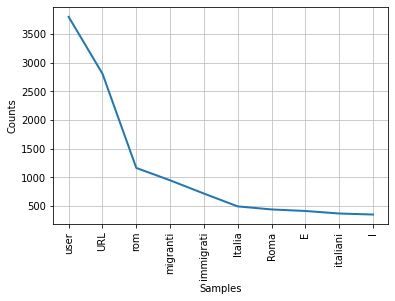

In [ ]:
words = word_tokenize(" ".join(df_train["text"].tolist())) # concatenate all rows
clean_words = []
for word in words:
    if word not in italian_stopwords and word.isalpha(): # if neither stopword nor punctuation
        clean_words.append(word)
fdist = FreqDist(clean_words)
fdist.plot(10)
plt.show()

WordCloud Representation of most frequent words

Negative:


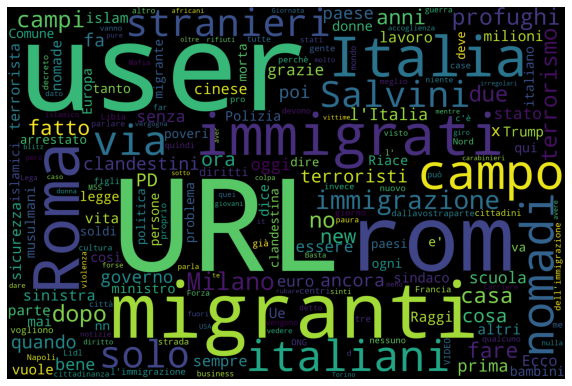

Positive:


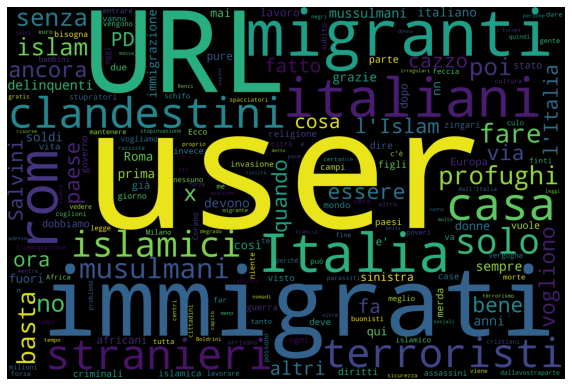

In [ ]:
total_corpus = " ".join(df_train["text"].tolist())

hate_corpus = df_train.loc[df_train["hs"] == 1]
hate_corpus = " ".join(hate_corpus["text"].tolist())

non_hate_corpus = df_train.loc[df_train["hs"] == 0]
non_hate_corpus = " ".join(non_hate_corpus["text"].tolist())

#print("Total:")
#wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = italian_stopwords).generate(total_corpus)
#plt.figure(figsize=(10, 10))
#plt.imshow(wordcloud1) 
#plt.axis("off");
#plt.show()

print("Negative:")
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = italian_stopwords).generate(non_hate_corpus)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off");
plt.show()

print("Positive:")
wordcloud2 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = italian_stopwords).generate(hate_corpus)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud2) 
plt.axis("off");
plt.show()

Distribution of the classes for **hate**

TRAINING
Not HS: 3253 - HS: 2216 

VALIDATION
Not HS: 818 - HS: 550 

TEST NEWS
Not HS: 319 - HS: 180 

TEST TWEETS
Not HS: 641 - HS: 621 



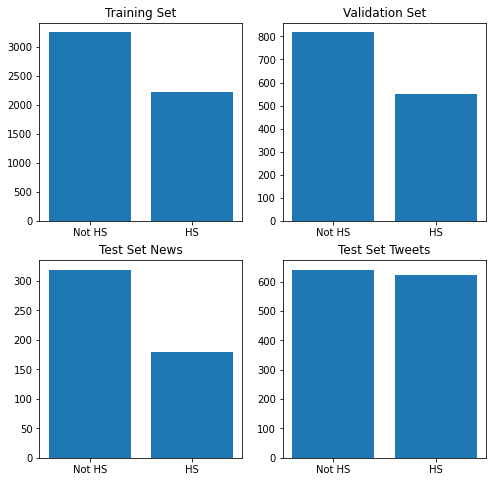

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

axs[0, 0].set_title("Training Set")
axs[0, 1].set_title("Validation Set")
axs[1, 0].set_title("Test Set News")
axs[1, 1].set_title("Test Set Tweets")

axs[0, 0].bar(x=["Not HS", "HS"], height=[df_train[df_train["hs"] == 0].shape[0], df_train[df_train["hs"] == 1].shape[0]])
axs[0, 1].bar(x=["Not HS", "HS"], height=[df_validation[df_validation["hs"] == 0].shape[0], df_validation[df_validation["hs"] == 1].shape[0]])
axs[1, 0].bar(x=["Not HS", "HS"], height=[df_test_news[df_test_news["hs"] == 0].shape[0], df_test_news[df_test_news["hs"] == 1].shape[0]])
axs[1, 1].bar(x=["Not HS", "HS"], height=[df_test_tweets[df_test_tweets["hs"] == 0].shape[0], df_test_tweets[df_test_tweets["hs"] == 1].shape[0]])

print("TRAINING")
print("Not HS:", df_train[df_train["hs"] == 0].shape[0], "- HS:", df_train[df_train["hs"] == 1].shape[0], "\n")
print("VALIDATION")
print("Not HS:", df_validation[df_validation["hs"] == 0].shape[0], "- HS:", df_validation[df_validation["hs"] == 1].shape[0], "\n")
print("TEST NEWS")
print("Not HS:", df_test_news[df_test_news["hs"] == 0].shape[0], "- HS:", df_test_news[df_test_news["hs"] == 1].shape[0], "\n")
print("TEST TWEETS")
print("Not HS:", df_test_tweets[df_test_tweets["hs"] == 0].shape[0], "- HS:", df_test_tweets[df_test_tweets["hs"] == 1].shape[0], "\n")

Distribution of the classes for **stereotype**

TRAINING
Not S: 3048 - S: 2421 

VALIDATION
Not S: 748 - S: 620 

TEST NEWS
Not S: 324 - S: 175 

TEST TWEETS
Not S: 693 - S: 569 



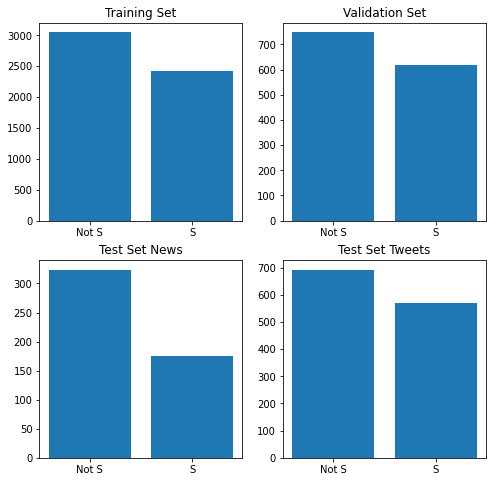

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

axs[0, 0].set_title("Training Set")
axs[0, 1].set_title("Validation Set")
axs[1, 0].set_title("Test Set News")
axs[1, 1].set_title("Test Set Tweets")

axs[0, 0].bar(x=["Not S", "S"], height=[df_train[df_train["stereotype"] == 0].shape[0], df_train[df_train["stereotype"] == 1].shape[0]])
axs[0, 1].bar(x=["Not S", "S"], height=[df_validation[df_validation["stereotype"] == 0].shape[0], df_validation[df_validation["stereotype"] == 1].shape[0]])
axs[1, 0].bar(x=["Not S", "S"], height=[df_test_news[df_test_news["stereotype"] == 0].shape[0], df_test_news[df_test_news["stereotype"] == 1].shape[0]])
axs[1, 1].bar(x=["Not S", "S"], height=[df_test_tweets[df_test_tweets["stereotype"] == 0].shape[0], df_test_tweets[df_test_tweets["stereotype"] == 1].shape[0]])

print("TRAINING")
print("Not S:", df_train[df_train["stereotype"] == 0].shape[0], "- S:", df_train[df_train["stereotype"] == 1].shape[0], "\n")
print("VALIDATION")
print("Not S:", df_validation[df_validation["stereotype"] == 0].shape[0], "- S:", df_validation[df_validation["stereotype"] == 1].shape[0], "\n")
print("TEST NEWS")
print("Not S:", df_test_news[df_test_news["stereotype"] == 0].shape[0], "- S:", df_test_news[df_test_news["stereotype"] == 1].shape[0], "\n")
print("TEST TWEETS")
print("Not S:", df_test_tweets[df_test_tweets["stereotype"] == 0].shape[0], "- S:", df_test_tweets[df_test_tweets["stereotype"] == 1].shape[0], "\n")

Correlation between Hate and Stereotype

In [ ]:
df_train.shape[0]

5469

In [ ]:
print("Hate and Stereotype: " + str(df_train[(df_train["hs"] == 1) & (df_train["stereotype"] == 1)].shape[0]))
print("Only Hate: " + str(df_train[(df_train["hs"] == 1) & (df_train["stereotype"] == 0)].shape[0]))
print("Only Stereotype: " + str(df_train[(df_train["hs"] == 0) & (df_train["stereotype"] == 1)].shape[0]))

Hate and Stereotype: 1610
Only Hate: 606
Only Stereotype: 811


## Preprocessing

In [ ]:
def preprocessing(text):
  # Remove URL tokens 
  text = re.sub(r"\bURL\b", " ", text)

  # Convert "camelCase" expressions in the form "camel case"
  text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text)

  # Convert all the text to lowercase
  text = text.lower()

  # Remove @user tokens 
  text = re.sub(r"@user", " ", text)

  # Remove all special characters, different from letters, numbers and spaces
  text = re.sub(r"[^\w\s\d]", " ", text)

  # Reduce all multiple spaces to a single one
  text = re.sub(r"\s+", " ", text)

  return text

In [ ]:
# Apply preprocessing function to all data
df_train["text"] = df_train["text"].map(lambda x: preprocessing(x))
df_validation["text"] = df_validation["text"].map(lambda x: preprocessing(x))
df_test_news["text"] = df_test_news["text"].map(lambda x: preprocessing(x))
df_test_tweets["text"] = df_test_tweets["text"].map(lambda x: preprocessing(x))

In [ ]:
df_train.head(100)

,id,text,hs,stereotype
2251,1097,è sbagliato doveva dire con la fornero italia...,0,0
977,2658,vada a dragona cittadini esasperati da rom e ...,0,1
809,2713,il dossier riservato sugli sbarchi nel 2017 ol...,0,0
2436,281,il discorso sui rom del lidl è complesso e non...,0,0
2228,1807,ivan rom di 20 anni morto nel rogo della sua b...,0,0
...,...,...,...,...
422,420,associazioni pro rom che ne pensate ovviamente...,0,1
6656,8857,disoccupazione alle stelle aziende che chiudon...,0,1
5737,9201,chiuso centro baobab siamo alle solite il mini...,1,1
881,2815,roma scatta l allerta terrorismo ma fanno più...,0,0


WordCloud Representation of most frequent words after preprocessing

Negative:


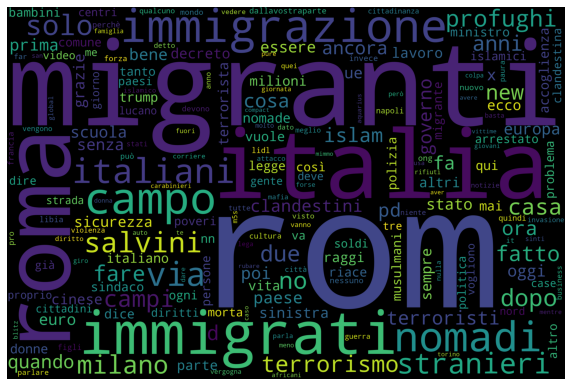

Positive:


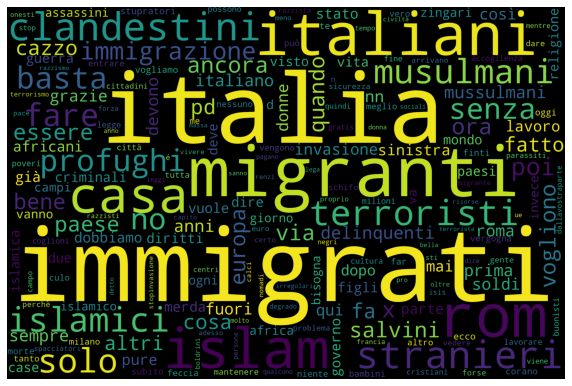

In [ ]:
total_corpus = " ".join(df_train["text"].tolist())

hate_corpus = df_train.loc[df_train["hs"] == 1]
hate_corpus = " ".join(hate_corpus["text"].tolist())

non_hate_corpus = df_train.loc[df_train["hs"] == 0]
non_hate_corpus = " ".join(non_hate_corpus["text"].tolist())

print("Negative:")
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = italian_stopwords).generate(non_hate_corpus)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off");
plt.show()

print("Positive:")
wordcloud2 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = italian_stopwords).generate(hate_corpus)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud2) 
plt.axis("off");
plt.show()

Distribution of the word "ROM"

In [ ]:
# Training
print("Hate: " + str(sum(df_train.loc[df_train["hs"] == 1]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Non Hate: " + str(sum(df_train.loc[df_train["hs"] == 0]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Stereotype: " + str(sum(df_train.loc[df_train["stereotype"] == 1]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Non Stereotype: " + str(sum(df_train.loc[df_train["stereotype"] == 0]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))

Hate: 274
Non Hate: 938
Stereotype: 559
Non Stereotype: 653


In [ ]:
# Test News
print("Hate: " + str(sum(df_test_news.loc[df_test_news["hs"] == 1]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Non Hate: " + str(sum(df_test_news.loc[df_test_news["hs"] == 0]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Stereotype: " + str(sum(df_test_news.loc[df_test_news["stereotype"] == 1]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Non Stereotype: " + str(sum(df_test_news.loc[df_test_news["stereotype"] == 0]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))

Hate: 11
Non Hate: 26
Stereotype: 11
Non Stereotype: 26


In [ ]:
# Test Tweets
print("Hate: " + str(sum(df_test_tweets.loc[df_test_tweets["hs"] == 1]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Non Hate: " + str(sum(df_test_tweets.loc[df_test_tweets["hs"] == 0]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Stereotype: " + str(sum(df_test_tweets.loc[df_test_tweets["stereotype"] == 1]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))
print("Non Stereotype: " + str(sum(df_test_tweets.loc[df_test_tweets["stereotype"] == 0]["text"].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))

Hate: 84
Non Hate: 131
Stereotype: 85
Non Stereotype: 130


## Utils Definition

Instantiation of Dataset objects

In [ ]:
ds_train = Dataset.from_dict(df_train)
ds_validation = Dataset.from_dict(df_validation)
ds_test_news = Dataset.from_dict(df_test_news)
ds_test_tweets = Dataset.from_dict(df_test_tweets)

Metrics to compute during training

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

Training Procedure: it takes the model, the training configuration in input, along with the training and validation data

In [ ]:
def train(model, args, ds_tok_train, ds_tok_validation): 
  trainer = Trainer(
    model = model, 
    args = args, 
    train_dataset = ds_tok_train,
    eval_dataset = ds_tok_validation,
    compute_metrics = compute_metrics
  )

  trainer.train()

  return trainer

Utility for the visualization of the statistics about the predictions, such as the precision-recall curve and the confusion matrix (both normalized and unnormalized)

In [ ]:
def plot_statistics(y, pred):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  ConfusionMatrixDisplay.from_predictions(y, pred, normalize=None, cmap=plt.cm.Blues, ax = axs[0])
  ConfusionMatrixDisplay.from_predictions(y, pred, normalize="true", cmap=plt.cm.Blues, values_format=".2f", ax = axs[1])
  plt.show()

  average_precision = average_precision_score(y, pred)
  precision, recall, _ = precision_recall_curve(y, pred)
  plt.step(recall, precision, color="b", alpha=0.2, where="post")
  plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title("2-class Precision-Recall curve (AP={0:0.2f})".format(average_precision))

##Task A - Hate Detection

In [ ]:
model_name_hate = "Hate-speech-CNERG/dehatebert-mono-italian"

Tokenization

In [ ]:
tokenizer_hate = AutoTokenizer.from_pretrained(model_name_hate)
tokenize_func = lambda sentences: tokenizer_hate(
    sentences["text"],
    padding="max_length", # pad to the maximum length accepted by the model
    truncation=True # truncate to the maximum length as specified above
)

ds_tok_hate_train = ds_train.map(tokenize_func, batched=True)
ds_tok_hate_validation = ds_validation.map(tokenize_func, batched=True)
ds_tok_hate_test_news = ds_test_news.map(tokenize_func, batched=True)
ds_tok_hate_test_tweets = ds_test_tweets.map(tokenize_func, batched=True)

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_hate, num_labels=2)

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

The model expects the target value in a column called **label**, so we rename our **hs** column

In [ ]:
ds_tok_hate_train = ds_tok_hate_train.rename_column("hs", "label")
ds_tok_hate_validation = ds_tok_hate_validation.rename_column("hs", "label");

In [ ]:
training_args_hate = TrainingArguments(
    output_dir="./results", # directory where predictions are written
    overwrite_output_dir=True, # overwrite previous content of output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=8, # batch size for each GPU core
    gradient_accumulation_steps=1, # number of steps to accumulate the gradient for, before doing backward pass
    gradient_checkpointing=True, # to save memory
    optim="adafactor", # optimizer to use
    save_steps=1000, # number of steps before checkpoint save
    save_total_limit=1, # limit the total amount of checkpoints
    warmup_steps=1000, # number of steps for linear warmup
    weight_decay=0.01, # weight decay to apply to all layers
    learning_rate=3e-5, # learning rate
    logging_steps=200, # number of update steps between two logs
    fp16=True, # use fp16 16-bit precision
    do_eval=True, # do evaluation on validation set
    evaluation_strategy="epoch"
)

trainer_hate = train(model, training_args_hate, ds_tok_hate_train, ds_tok_hate_validation)
trainer_hate.evaluate()

Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, stereotype, text. If id, stereotype, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5469
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2052
  Number of trainable parameters = 167357954


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.486700,0.602494,0.752924,0.743939,0.637662,0.892727
2,0.472200,0.486051,0.777778,0.749588,0.685241,0.827273
3,0.369900,0.575969,0.792398,0.750877,0.725424,0.778182


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, stereotype, text. If id, stereotype, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1368
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, stereotype, text. If id, stereotype, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1368
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-20

{'eval_loss': 0.575969398021698,
 'eval_accuracy': 0.7923976608187134,
 'eval_f1': 0.7508771929824563,
 'eval_precision': 0.7254237288135593,
 'eval_recall': 0.7781818181818182,
 'eval_runtime': 16.6879,
 'eval_samples_per_second': 81.976,
 'eval_steps_per_second': 10.247,
 'epoch': 3.0}

Perform the prediction over validation and test set, by getting the index of the maximum score for each row (0 means non-hate, whereas 1 means hate)

In [ ]:
preds_validation_hate = np.argmax(trainer_hate.predict(ds_tok_hate_validation).predictions, axis=-1)
preds_news_hate = np.argmax(trainer_hate.predict(ds_tok_hate_test_news).predictions, axis=-1)
preds_tweets_hate = np.argmax(trainer_hate.predict(ds_tok_hate_test_tweets).predictions, axis=-1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, stereotype, text. If id, stereotype, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1368
  Batch size = 8


The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, stereotype, text, hs. If id, stereotype, text, hs are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 499
  Batch size = 8


The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, stereotype, text, hs. If id, stereotype, text, hs are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1262
  Batch size = 8


###Error Analysis

In [ ]:
report_validation = classification_report(ds_validation["hs"], preds_validation_hate, target_names=["nhs", "hs"])
report_test_news = classification_report(ds_test_news["hs"], preds_news_hate, target_names=["nhs", "hs"])
report_test_tweets = classification_report(ds_test_tweets["hs"], preds_tweets_hate, target_names=["nhs", "hs"])
print("Validation")
print(report_validation, "\n")
print("Test News")
print(report_test_news, "\n")
print("Test Tweets")
print(report_test_tweets, "\n")

Validation
              precision    recall  f1-score   support

         nhs       0.84      0.80      0.82       818
          hs       0.73      0.78      0.75       550

    accuracy                           0.79      1368
   macro avg       0.78      0.79      0.79      1368
weighted avg       0.80      0.79      0.79      1368
 

Test News
              precision    recall  f1-score   support

         nhs       0.73      0.95      0.82       319
          hs       0.80      0.37      0.50       180

    accuracy                           0.74       499
   macro avg       0.77      0.66      0.66       499
weighted avg       0.75      0.74      0.71       499
 

Test Tweets
              precision    recall  f1-score   support

         nhs       0.79      0.69      0.74       641
          hs       0.72      0.81      0.76       621

    accuracy                           0.75      1262
   macro avg       0.75      0.75      0.75      1262
weighted avg       0.76      0.75    

TEST NEWS


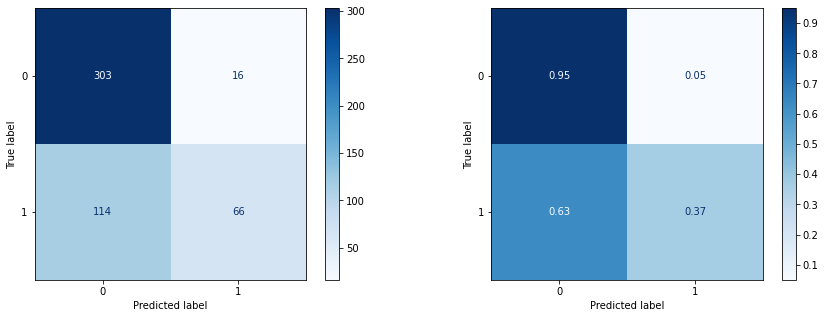

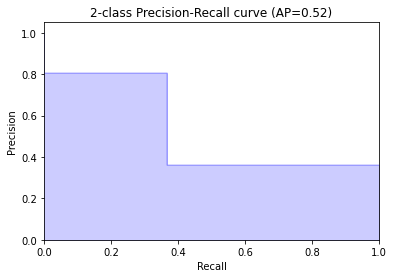

In [ ]:
print("TEST NEWS")
plot_statistics(ds_test_news["hs"], preds_news_hate)

TEST TWEETS


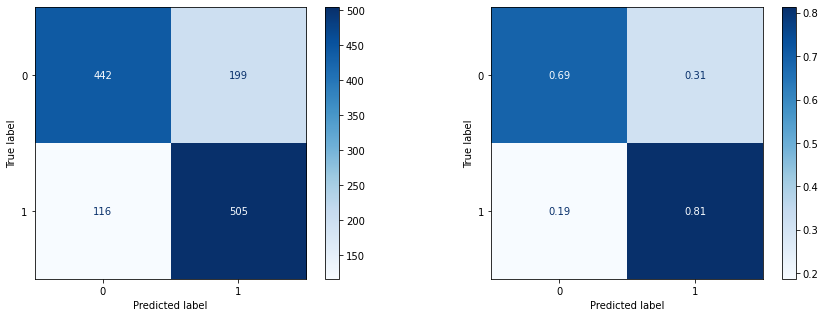

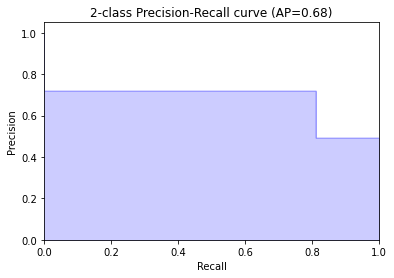

In [ ]:
print("TEST TWEETS")
plot_statistics(ds_test_tweets["hs"], preds_tweets_hate)

NEWS - Classification Examples

In [ ]:
# Collect all the False Positives and False Negatives respectively into fp_news and fn_news lists

fp_news = []
fn_news = []

for i in range(df_test_news.shape[0]):
  if df_test_news["hs"][i] == 0 and preds_news_hate[i] == 1:
    fp_news.append(i)

  if df_test_news["hs"][i] == 1 and preds_news_hate[i] == 0:
    fn_news.append(i)

In [ ]:
# Show 10 random instances with prediction

for i in random.sample(range(df_test_news.shape[0]), 10):
  print("News", df_test_news["id"][i])
  print(df_test_news["text"][i])
  print("Actual:", "H" if df_test_news["hs"][i] == 1 else "NH", "- Predicted:", 
        "H" if preds_news_hate[i] == 1 else "NH", "\n")

News 10097
il piano degli islamici italiani due milioni di profughi
Actual: H - Predicted: H 

News 12241
sui migranti conte si smarca e sfida salvini
Actual: NH - Predicted: NH 

News 11714
io ostaggio degli immigrati ecco come mi hanno ridotta
Actual: H - Predicted: NH 

News 10530
m5s di maio superiamo i campi rom ma sgomberiamo anche chi occupa abusivamente come casa pound 
Actual: NH - Predicted: NH 

News 11144
ecco come l immigrazione ha ucciso il turismo a fiuggi
Actual: H - Predicted: NH 

News 11487
con appendino torino mecca dei musulmani
Actual: H - Predicted: NH 

News 11114
le spese pazze del governo oltre 23mila euro per i rom
Actual: H - Predicted: NH 

News 11591
crotone barca a vela con 51 migranti curdi si capovolge vicino alla costa i cittadini salvano i naufraghi
Actual: NH - Predicted: NH 

News 10217
niente più affari con i migranti e adesso cooperative e sindacati scendono in piazza
Actual: NH - Predicted: NH 

News 11830
ong malta non vuole i migranti prima acc

False Positives

In [ ]:
# Show 10 randomly picked samples among the false positives

for i in random.sample(range(len(fp_news)), min(len(fp_news), 10)):
  print("News", df_test_news["id"][fp_news[i]])
  print(df_test_news["text"][fp_news[i]])
  print("Actual:", "H" if df_test_news["hs"][fp_news[i]] == 1 else "NH", "- Predicted:", 
        "H" if preds_news_hate[fp_news[i]] == 1 else "NH", "\n")

News 10959
calci e pugni alle auto parcheggiate in strada arrestati due immigrati
Actual: NH - Predicted: H 

News 10977
diciotti migranti costretti a restare a bordo chiedono un risarcimento all italia
Actual: NH - Predicted: H 

News 11129
caserta immigrati in bici travolti e uccisi da auto preso il pirata ho sentito urto ma non avevo capito 
Actual: NH - Predicted: H 

News 11823
lecco immigrato fra cacca e pipì tra i mezzi dei vigili poi le botte all agente di polizia
Actual: NH - Predicted: H 

News 11061
soccorsi al largo di lampedusa quaranta migranti tra loro donne e bambine
Actual: NH - Predicted: H 

News 11901
lite sui migranti mossa di maio porte aperte a donne e bambini gelo salvini basta ricatti 
Actual: NH - Predicted: H 

News 10941
finanzia l invasione degli immigrati ecco la prova la vergogna di george soros padrone d italia
Actual: NH - Predicted: H 

News 10650
via crucis papa francesco prega per i migranti porte chiuse per cuori blindati da calcoli politici 
Actual

False Negatives

In [ ]:
# Show 10 randomly picked samples among the false negatives

for i in random.sample(range(len(fn_news)), min(len(fn_news), 10)):
  print("News", df_test_news["id"][fn_news[i]])
  print(df_test_news["text"][fn_news[i]])
  print("Actual:", "H" if df_test_news["hs"][fn_news[i]] == 1 else "NH", "- Predicted:", 
        "H" if preds_news_hate[fn_news[i]] == 1 else "NH", "\n")

News 11316
così gli immigrati sostituiscono e umiliano gesù la denuncia di socci il volantino vergogna foto
Actual: H - Predicted: NH 

News 10180
trump apre il fronte messicano via i migranti o metto i dazi 
Actual: H - Predicted: NH 

News 10098
casa popolare ai rom anche a casal de pazzi residenti sul piede di guerra
Actual: H - Predicted: NH 

News 10695
degrado val melaina rissa a bottigliate tra rom in pieno giorno
Actual: H - Predicted: NH 

News 10029
c è la scuola via i migranti siamo contrari all apartheid ma ora serve più sicurezza 
Actual: H - Predicted: NH 

News 10976
gli immigrati fanno perdere all italia 5 miliardi l anno
Actual: H - Predicted: NH 

News 11308
così renzi si è venduto l italia immigrati parla l ex ministro in cambio di soldi suicidio
Actual: H - Predicted: NH 

News 11210
i dieci sindaci che rifiutano i clandestini e vengono denunciati
Actual: H - Predicted: NH 

News 10363
un pm aveva appena liberato l immigrato che ha attaccato gli agenti a torino
Actu

Distribution of the word "ROM" among wrong classified samples

In [ ]:
print("#FN: " + str(len(df_test_news["text"][fn_news].tolist())))
print("#FN with ROM: " + str(sum(df_test_news["text"][fn_news].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))

#FN: 114
#FN with ROM: 11


TWEETS - Classification Examples

In [ ]:
# Collect all the False Positives and False Negatives respectively into fp_tweets and fn_tweets lists

fp_tweets = []
fn_tweets = []

for i in range(df_test_tweets.shape[0]):
  if df_test_tweets["hs"][i] == 0 and preds_tweets_hate[i] == 1:
    fp_tweets.append(i)

  if df_test_tweets["hs"][i] == 1 and preds_tweets_hate[i] == 0:
    fn_tweets.append(i)

In [ ]:
# Show 10 random instances with prediction

for i in random.sample(range(df_test_tweets.shape[0]), 10):
  print("Tweet", df_test_tweets["id"][i])
  print(df_test_tweets["text"][i])
  print("Actual:", "H" if df_test_tweets["hs"][i] == 1 else "NH", "- Predicted:", 
        "H" if preds_tweets_hate[i] == 1 else "NH", "\n")

Tweet 11781
 alle idiote pdinne gli serve questo trattamento forse solo dopo si ricrederanno e dico forse tanto sono coglione idiote dementi io dico unica salvezza nuove crociate contro l islam viva riccardo cuor di leone nuove crociate altro che accoglienza 
Actual: H - Predicted: H 

Tweet 12096
redistribuire come vacche degli immigrati clandestini gente che nasconde documenti e mente allo stato devono andare in galera loro e l equipaggio che li ha favoreggiati e la sea watch requisita lo dobbiamo ai terremotati ancora senza soldi mentre lo stato paga delinquenti 
Actual: H - Predicted: H 

Tweet 10043
non ammettono che le persone istintivamente a pelle si fidino di perché finora è unico che ha capito la priorità assoluta per italia adesso pericolo islam e africa da scongiurare al resto penseremo propedeutico 
Actual: H - Predicted: H 

Tweet 11173
 i rom gli africani in generale non hanno il nostro stesso concetto di genitorialità spesso per loro i figli sono soltanto degli strument

False Positives

In [ ]:
# Show 10 randomly picked samples among the false positives

for i in random.sample(range(len(fp_tweets)), min(len(fp_tweets), 10)):
  print("Tweet", df_test_tweets["id"][fp_tweets[i]])
  print(df_test_tweets["text"][fp_tweets[i]])
  print("Actual:", "H" if df_test_tweets["hs"][fp_tweets[i]] == 1 else "NH", "- Predicted:", 
        "H" if preds_tweets_hate[fp_tweets[i]] == 1 else "NH", "\n")

Tweet 11193
non è questione di preti rossi ma finché saranno guidati da vescovi collaboratori di un papa che si e ci svende ai mussulmani 
Actual: NH - Predicted: H 

Tweet 11669
bisogna intervenire subito questa da i numeri sta diventando pericolosa kyenge l europa ha bisogno di almeno 50 milioni di immigrati 
Actual: NH - Predicted: H 

Tweet 10924
ecco un altro soldatino della chiesa islamica di bergoglio impegnato ad allontanare quanti più fedeli possibile dalla religionecristiana per consentire la crescita incontrastata dell islam 
Actual: NH - Predicted: H 

Tweet 11206
 invece di fare la guerra ai migranti fatela agli italiani over 30 aprite i forni come in germania e li mettete tutti dentro tanto sono già morti in italia si agevola solo il giovane max 29 anni il resto dei disoccupati è merda sterminiamoli 
Actual: NH - Predicted: H 

Tweet 10425
 dovrebbero sbarcare ad amburgo perché la nave batte bandiera tedesca perché i migranti hanno sborsato quasi 300 000 per arrivare in g

False Negatives

In [ ]:
# Show 10 randomly picked samples among the false negatives

for i in random.sample(range(len(fn_tweets)), min(len(fn_tweets), 10)):
  print("Tweet", df_test_tweets["id"][fn_tweets[i]])
  print(df_test_tweets["text"][fn_tweets[i]])
  print("Actual:", "H" if df_test_tweets["hs"][fn_tweets[i]] == 1 else "NH", "- Predicted:", 
        "H" if preds_tweets_hate[fn_tweets[i]] == 1 else "NH", "\n")

Tweet 11963
pentito islamico confessa in italia esercito di jihadisti sbarcati con i governi pd solo ieri qualcuno del pd diceva riferendosi ai 49 ancora sulla ong su quella nave potrebbe esserci un prossimo premio nobel sì certo un nobel in stragi e terrorismo bei mi schiaffi 
Actual: H - Predicted: NH 

Tweet 10871
 zingari dovete morire di fame grida e proteste contro i nomadi a roma siete contenti piddini di merda questi sono i focalai della futura rivoluzione civile 
Actual: H - Predicted: NH 

Tweet 12156
 vi abbiamo votato anche per non vedere più sbarcare gente indesiderata sulle nostre coste porti chiusi e spartire i migranti già presenti sul nostro territorio con gli altri paesi della ue da subito 
Actual: H - Predicted: NH 

Tweet 11539
ma sicuramente si raccatterà qualche voto sicuramente votano gli immigrati negri si allora
Actual: H - Predicted: NH 

Tweet 11288
i soldi dei disabili ai migranti la regione emilia romagna destina la metà dei fondi destinati alle fasce debol

Distribution of the word "ROM" among wrong classified samples

In [ ]:
print("#FN: " + str(len(df_test_tweets["text"][fn_tweets].tolist())))
print("#FN with ROM: " + str(sum(df_test_tweets["text"][fn_tweets].map(lambda x: 1 if len(re.findall(r"\brom\b", x)) != 0 else 0))))

#FN: 116
#FN with ROM: 33


##Task B - Stereotype Detection

In [ ]:
model_name_stereotype = "xlm-roberta-base"

In [ ]:
tokenizer_stereotype = AutoTokenizer.from_pretrained(model_name_stereotype)
tokenize_func = lambda sentences: tokenizer_stereotype(
    sentences["text"],
    padding="max_length",# pad to the maximum length accepted by the model
    truncation=True # truncate to the maximum length as specified above
)

ds_tok_stereotype_train = ds_train.map(tokenize_func, batched=True)
ds_tok_stereotype_validation = ds_validation.map(tokenize_func, batched=True)
ds_tok_stereotype_test_news = ds_test_news.map(tokenize_func, batched=True)
ds_tok_stereotype_test_tweets = ds_test_tweets.map(tokenize_func, batched=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/42f548f32366559214515ec137cdd16002968bf6/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

loading file sentencepiece.bpe.model from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/42f548f32366559214515ec137cdd16002968bf6/sentencepiece.bpe.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/42f548f32366559214515ec137cdd16002968bf6/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/42f548f32366559214515ec137cdd16002968bf6/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_r

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_stereotype, num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/42f548f32366559214515ec137cdd16002968bf6/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/42f548f32366559214515ec137cdd16002968bf6/pytorch_model.bin
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

The model expects the target value in a column called **label**, so we rename our **stereotype** column

In [ ]:
ds_tok_stereotype_train = ds_tok_stereotype_train.rename_column("stereotype", "label")
ds_tok_stereotype_validation = ds_tok_stereotype_validation.rename_column("stereotype", "label");

In [ ]:
training_args_stereotype = TrainingArguments(
    output_dir="./results", # directory where predictions are written
    overwrite_output_dir=True, # overwrite previous content of output directory
    num_train_epochs=5, # number of training epochs
    per_device_train_batch_size=8, # batch size for each GPU core
    gradient_accumulation_steps=1, # number of steps to accumulate the gradient for, before doing backward pass
    gradient_checkpointing=True, # to save memory
    optim="adafactor", # optimizer to use
    save_steps=1000, # number of steps before checkpoint save
    save_total_limit=1, # limit the total amount of checkpoints
    warmup_steps=1000, # number of steps for linear warmup
    weight_decay=0.01, # weight decay to apply to all layers
    learning_rate=3e-5, # learning rate
    logging_steps=200, # number of update steps between two logs
    fp16=True, # use fp16 16-bit precision
    do_eval=True, # do evaluation on validation set
    evaluation_strategy="epoch"
)

trainer_stereotype = train(model, training_args_stereotype, ds_tok_stereotype_train, ds_tok_stereotype_validation)
trainer_stereotype.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, text, hs. If id, text, hs are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5469
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3420
  Number of trainable parameters = 278045186


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.662900,0.667700,0.619152,0.390643,0.710638,0.269355
2,0.597700,0.555675,0.728070,0.706161,0.691950,0.720968
3,0.509900,0.691295,0.730994,0.661765,0.769231,0.580645
4,0.383700,0.641117,0.725877,0.717833,0.672779,0.769355
5,0.304600,1.009765,0.736842,0.708266,0.711726,0.704839


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, text, hs. If id, text, hs are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1368
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, text, hs. If id, text, hs are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1368
  Batch size = 8
Saving model checkpoint to

{'eval_loss': 1.009764552116394,
 'eval_accuracy': 0.7368421052631579,
 'eval_f1': 0.7082658022690438,
 'eval_precision': 0.7117263843648208,
 'eval_recall': 0.7048387096774194,
 'eval_runtime': 15.9045,
 'eval_samples_per_second': 86.013,
 'eval_steps_per_second': 10.752,
 'epoch': 5.0}

Perform the prediction over validation and test set, by getting the index of the maximum score for each row (0 means non-stereotype, whereas 1 means stereotype)

In [ ]:
preds_validation_stereotype = np.argmax(trainer_stereotype.predict(ds_tok_stereotype_validation).predictions, axis=-1)
preds_news_stereotype = np.argmax(trainer_stereotype.predict(ds_tok_stereotype_test_news).predictions, axis=-1)
preds_tweets_stereotype = np.argmax(trainer_stereotype.predict(ds_tok_stereotype_test_tweets).predictions, axis=-1)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, text, hs. If id, text, hs are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1368
  Batch size = 8


The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, stereotype, text, hs. If id, stereotype, text, hs are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 499
  Batch size = 8


The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: id, stereotype, text, hs. If id, stereotype, text, hs are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1262
  Batch size = 8


###Error Analysis

In [ ]:
report_validation = classification_report(ds_validation["stereotype"], preds_validation_stereotype, target_names=["ns", "s"])
report_test_news = classification_report(ds_test_news["stereotype"], preds_news_stereotype, target_names=["ns", "s"])
report_test_tweets = classification_report(ds_test_tweets["stereotype"], preds_tweets_stereotype, target_names=["ns", "s"])
print("Validation")
print(report_validation, "\n")
print("Test News")
print(report_test_news, "\n")
print("Test Tweets")
print(report_test_tweets, "\n")

Validation
              precision    recall  f1-score   support

          ns       0.76      0.76      0.76       748
           s       0.71      0.70      0.71       620

    accuracy                           0.74      1368
   macro avg       0.73      0.73      0.73      1368
weighted avg       0.74      0.74      0.74      1368
 

Test News
              precision    recall  f1-score   support

          ns       0.74      0.92      0.82       324
           s       0.73      0.41      0.53       175

    accuracy                           0.74       499
   macro avg       0.74      0.67      0.67       499
weighted avg       0.74      0.74      0.72       499
 

Test Tweets
              precision    recall  f1-score   support

          ns       0.83      0.68      0.75       693
           s       0.68      0.83      0.75       569

    accuracy                           0.75      1262
   macro avg       0.75      0.75      0.75      1262
weighted avg       0.76      0.75    

TEST NEWS


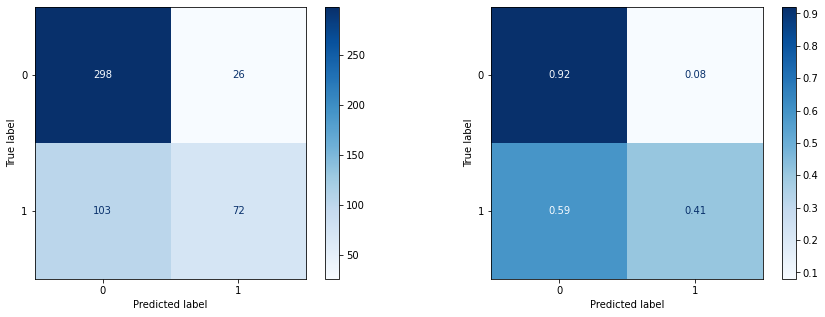

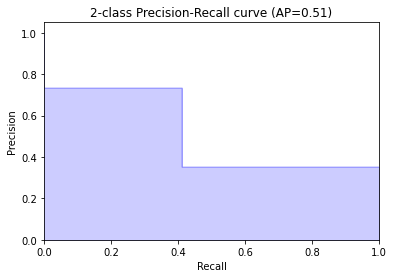

In [ ]:
print("TEST NEWS")
plot_statistics(ds_test_news["stereotype"], preds_news_stereotype)

TEST TWEETS


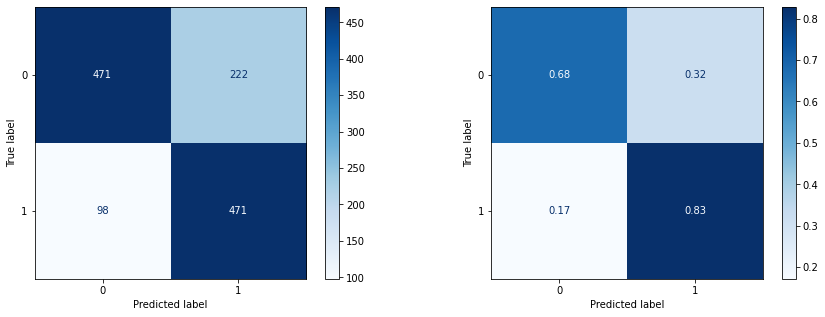

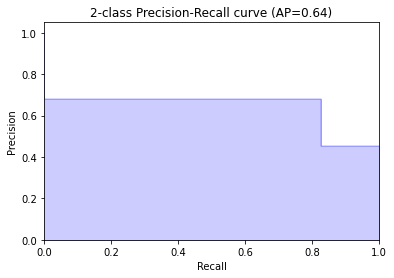

In [ ]:
print("TEST TWEETS")
plot_statistics(ds_test_tweets["stereotype"], preds_tweets_stereotype)

NEWS - Classification Examples

In [ ]:
# Collect all the False Positives and False Negatives respectively into fp_news and fn_news lists

fp_news = []
fn_news = []

for i in range(df_test_news.shape[0]):
  if df_test_news["stereotype"][i] == 0 and preds_news_stereotype[i] == 1:
    fp_news.append(i)

  if df_test_news["stereotype"][i] == 1 and preds_news_stereotype[i] == 0:
    fn_news.append(i)

In [ ]:
# Show 10 random instances with prediction

for i in random.sample(range(df_test_news.shape[0]), 10):
  print("News", df_test_news["id"][i])
  print(df_test_news["text"][i])
  print("Actual:", "S" if df_test_news["stereotype"][i] == 1 else "NS", "- Predicted:", 
        "S" if preds_news_stereotype[i] == 1 else "NS", "\n")

News 10097
il piano degli islamici italiani due milioni di profughi
Actual: S - Predicted: NS 

News 12241
sui migranti conte si smarca e sfida salvini
Actual: NS - Predicted: NS 

News 11714
io ostaggio degli immigrati ecco come mi hanno ridotta
Actual: S - Predicted: S 

News 10530
m5s di maio superiamo i campi rom ma sgomberiamo anche chi occupa abusivamente come casa pound 
Actual: NS - Predicted: NS 

News 11144
ecco come l immigrazione ha ucciso il turismo a fiuggi
Actual: S - Predicted: NS 

News 11487
con appendino torino mecca dei musulmani
Actual: S - Predicted: NS 

News 11114
le spese pazze del governo oltre 23mila euro per i rom
Actual: S - Predicted: S 

News 11591
crotone barca a vela con 51 migranti curdi si capovolge vicino alla costa i cittadini salvano i naufraghi
Actual: NS - Predicted: NS 

News 10217
niente più affari con i migranti e adesso cooperative e sindacati scendono in piazza
Actual: NS - Predicted: NS 

News 11830
ong malta non vuole i migranti prima acco

False Positives

In [ ]:
# Show 10 randomly picked samples among the false positives

for i in random.sample(range(len(fp_news)), min(len(fp_news), 10)):
  print("News", df_test_news["id"][fp_news[i]])
  print(df_test_news["text"][fp_news[i]])
  print("Actual:", "S" if df_test_news["stereotype"][fp_news[i]] == 1 else "NS", "- Predicted:", 
        "S" if preds_news_stereotype[fp_news[i]] == 1 else "NS", "\n")

News 10006
i rom hanno diritto alla casa e i residenti di casal bruciato contestano la raggi
Actual: NS - Predicted: S 

News 10652
casal bruciato raggi famiglia rom ha diritto alla casa legge si rispetta 
Actual: NS - Predicted: S 

News 10243
investe e uccide un migrante in bici si ferma ma rischia il linciaggio salvato dalla polizia
Actual: NS - Predicted: S 

News 11650
lele mora picchiato e derubato di 40mila euro in campo rom per finto affare indagini della procura di milano
Actual: NS - Predicted: S 

News 10794
barchino di migranti tenta di arrivare a remi in sardegna
Actual: NS - Predicted: S 

News 10974
accusa bimbo rom di furto e lo ferisce con una lama arrestato
Actual: NS - Predicted: S 

News 12046
sequestrato in sicilia il tesoro degli scafisti ristoranti immobili e aziende con soldi tratta migranti
Actual: NS - Predicted: S 

News 11881
crotone barca naufragata e migranti in mare gli scafisti se ne vanno in hotel arrestati
Actual: NS - Predicted: S 

News 10244
roma la

False Negatives

In [ ]:
# Show 10 randomly picked samples among the false negatives

for i in random.sample(range(len(fn_news)), min(len(fn_news), 10)):
  print("News", df_test_news["id"][fn_news[i]])
  print(df_test_news["text"][fn_news[i]])
  print("Actual:", "S" if df_test_news["stereotype"][fn_news[i]] == 1 else "NS", "- Predicted:", 
        "S" if preds_news_stereotype[fn_news[i]] == 1 else "NS", "\n")

News 11344
ergastolo al somalo bestia cosa faceva ai profughi come ha reagito col giudice
Actual: S - Predicted: NS 

News 11287
formaggi olio pomodori e vino il lavoro degli immigrati che mantiene vive le nostre campagne
Actual: S - Predicted: NS 

News 10182
anziana rapinata sull autobus i due nomadi in fuga si rifugiano al campo di via candoni
Actual: S - Predicted: NS 

News 11897
atti osceni davanti ai bambini il parco di milano in balìa dei migranti
Actual: S - Predicted: NS 

News 10285
carpi aggressione ad una coppia di fidanzati fermati tre stranieri
Actual: S - Predicted: NS 

News 11144
ecco come l immigrazione ha ucciso il turismo a fiuggi
Actual: S - Predicted: NS 

News 10639
immigrati la verità nascosta sapete cosa stanno per fare all italia meloni apocalittica
Actual: S - Predicted: NS 

News 10488
il sindaco anti immigrati una rivoluzione nel pd come ripulisco tutto 
Actual: S - Predicted: NS 

News 10146
immigrati ammiraglio brutale ora basta balle ecco chi trama cont

TWEETS - Classification Examples

In [ ]:
# Collect all the False Positives and False Negatives respectively into fp_tweets and fn_tweets lists

fp_tweets = []
fn_tweets = []

for i in range(df_test_tweets.shape[0]):
  if df_test_tweets["stereotype"][i] == 0 and preds_tweets_stereotype[i] == 1:
    fp_tweets.append(i)

  if df_test_tweets["stereotype"][i] == 1 and preds_tweets_stereotype[i] == 0:
    fn_tweets.append(i)

In [ ]:
# Show 10 random instances with prediction

for i in random.sample(range(df_test_tweets.shape[0]), 10):
  print("Tweet", df_test_tweets["id"][i])
  print(df_test_tweets["text"][i])
  print("Actual:", "S" if df_test_tweets["stereotype"][i] == 1 else "NS", "- Predicted:", 
        "S" if preds_tweets_stereotype[i] == 1 else "NS", "\n")

Tweet 10100
stazione di frosinone anche qui inps pd con i migranti risorse risollevano l economia del paese e dormono e vivono negli sprar mentre gli italiani pagano vitto e alloggio roma napoli ovunque sempre la stessa musica salvininonmollare 
Actual: S - Predicted: S 

Tweet 11537
più crudele del mare in cui annegano è il mare di indifferenza verso i migranti brividi e lacrime di dolore e rabbia grazie dottor che tempo che fa
Actual: NS - Predicted: NS 

Tweet 10768
 ma quando lavori qui quelli che stanno lavorando da giugno sono i nostri ragazzi del che non hanno il tempo manco di andare in bagno e tu fai il bellino in giro per l italia e i migranti entrano senza permesso smettila di fare il bimbominkia
Actual: NS - Predicted: S 

Tweet 10110
nuovo comunicato appena pubblicato libia e terrorismo 
Actual: NS - Predicted: NS 

Tweet 10852
 migranti il pd mise in atto una vera e propria fabbrica dell accoglienza con stipendiati ora disperati e manifestanti per carenza di neri le fabbr

False Positives

In [ ]:
# Show 10 randomly picked samples among the false positives

for i in random.sample(range(len(fp_tweets)), min(len(fp_tweets), 10)):
  print("Tweet", df_test_tweets["id"][fp_tweets[i]])
  print(df_test_tweets["text"][fp_tweets[i]])
  print("Actual:", "S" if df_test_tweets["stereotype"][fp_tweets[i]] == 1 else "NS", "- Predicted:", 
        "S" if preds_tweets_stereotype[fp_tweets[i]] == 1 else "NS", "\n")

Tweet 11529
se io prendo una colf o una badante me la pago non chiedo di condividere il costo alla comunità se i sinistri vogliono i migranti se li paghino e nn vengano a rompere i coglioni agli italiani 
Actual: NS - Predicted: S 

Tweet 10512
se passate il vostro tempo a controllare dove va la alan kurdi per paura dell invasione di 50 persone ve lo dico avete un problema serio e non è l immigrazione 
Actual: NS - Predicted: S 

Tweet 10973
 cambio argomento m5s e morte degli italiani no gas no tav siete complici dei migranti della diciotti a mettere bombe in ue no create lavoro il reddito cittadinanza va ai migranti e rom al voto subito basta m5s con il trafficante di droga a di battista 
Actual: NS - Predicted: S 

Tweet 11645
visto così sembrerebbe uno di quei classici tipi che vanno a comprare champagne nei campi rom invece è il direttore di raiuno o due o tre o raiminchia o una di quelle robe lì lele mora separati alla nascita 
Actual: NS - Predicted: S 

Tweet 12195
 le paure vo

False Negatives

In [ ]:
# Show 10 randomly picked samples among the false negatives

for i in random.sample(range(len(fn_tweets)), min(len(fn_tweets), 10)):
  print("Tweet", df_test_tweets["id"][fn_tweets[i]])
  print(df_test_tweets["text"][fn_tweets[i]])
  print("Actual:", "S" if df_test_tweets["stereotype"][fn_tweets[i]] == 1 else "NS", "- Predicted:", 
        "S" if preds_tweets_stereotype[fn_tweets[i]] == 1 else "NS", "\n")

Tweet 10061
a napoli regnano gli immigrati la situazione è drammatica video 
Actual: S - Predicted: NS 

Tweet 11515
lo chiamo occupazione straniera e la combatto a costo della vita quello che stanno cercando di fare con noi
Actual: S - Predicted: NS 

Tweet 11794
chi non ha diritto a rimanere in italia deve uscire dagli sprar ed essere rimpatriato siamo stufi di mantenere tutti i migranti di questo mondo anche chi e arrivato senza documenti violando le leggi e senza avere alcun diritto di rimanere in italia portichiusi 
Actual: S - Predicted: NS 

Tweet 10745
ascoltate cosa è successo pochi mesi fa nella rimessa atac di via candoni a roma che ho visitato stamattina è inammissibile che in caso di problemi tecnici gli operatori devono chiedere permesso ai vicini del campo nomadi per poter accedere alla struttura e riparare il guasto 
Actual: S - Predicted: NS 

Tweet 11314
borseggiatrici rom tutte incinte scatenate sulla linea rossa della metropolitana milanese in occasione della fiera 